# Фреймворк PyTorch для разработки искусственных нейронных сетей
# Урок 4. CNN Свертки

# <font color='red'>Практическое задание</font>

- Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) сверточной сетью (самописной)
- Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50
- Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50 с аугментацией (самописной, с использованием Pytorch встроенных методов)

Выполнил ___Соковнин ИЛ___

RESNET50 - https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/

### <font color='blue'>1. Сделаем необходимые импорты</font>

In [2]:
# !pip install torch torchvision

In [1]:
import torch
import numpy as np

from torch import nn
import torchvision

import torch.nn.functional as F
from tqdm import tqdm

### <font color='blue'>2. Загрузим датасет CIFAR-100, сразу же создадим dataloader для него</font>

In [2]:
from torch import optim
import torchvision.transforms as transforms
import torchvision
from torchvision import models
# from torchvision import transforms, datasets
import matplotlib.pyplot as plt ### воспользуемся для отображения изображения

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The CIFAR-100 dataset
This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

https://www.cs.toronto.edu/~kriz/cifar.html

In [3]:
# Задаем преобразование для применения к CIFAR
# Необходимые трансформации

# Нейронная сеть обучается лучше, когда входные данные нормализованы так,
# что их значения находятся в диапазоне от -1 до 1 или от 0 до 1. 
# Для датасета CIFAR c 3 каналами (по одному на каждый цвет из RGB спектра) 
# надо указывать среднее и стандартное отклонение для каждого.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Численные трансформации могут быть соединены вместе в список при использовании функции Compose().
# Устанавливается преобразование, которое конвертирует входной датасет в PyTorch тензор.
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),  # Обрезает данное изображение по центру
                                normalize,
                                transforms.ToTensor()])

trans = transforms.Compose([transforms.ToTensor(), normalize]) 

train_transform = transforms.Compose([# transforms.Resize(256),
                                      
                                      transforms.RandomCrop(32, padding=4),  # Обрезает данное изображение по центру
                                      transforms.ToTensor(),
                                      normalize])

test_transform = transforms.Compose([transforms.ToTensor(),
                                          normalize])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


### __2.1 Загружаем CIFAR-100__

In [4]:
# загружаем CIFAR-100
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                            train=True,  
                                            # transform=transforms.ToTensor(), 
                                            transform=train_transform, 
                                            # transform=trans, 
                                            download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            # transform=transforms.ToTensor(),
                                            transform=test_transform,
                                            # transform=trans, 
                                            download=True)


image, label = train_dataset[0]  # 0-й рисунок ()
print(image.size())
print(label)

# размерность рисунка 3 * 32 * 32

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 6


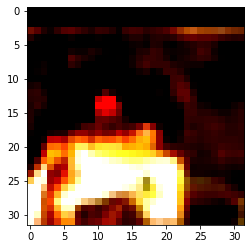

In [5]:
# print('*' * 50)
print(f'label: {label}')
# print('*' * 50)
plt.imshow(image.permute(1, 2, 0).numpy())  # image.permute - Convert image to proper dimension PyTorch


### __2.2 Оборачиваем в Dataloader__

In [6]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True,  # True - чтобы данные перетасовывались в каждую эпоху.
                                           num_workers=3)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          num_workers=1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
# Let’s look at the images. - https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1

from torchvision.utils import make_grid
def show_batch(dl):
    for batch in dl:
        images,labels = batch
        fig, ax = plt.subplots(figsize=(7.5,7.5))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(make_grid(images[:20],nrow=5).permute(1,2,0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


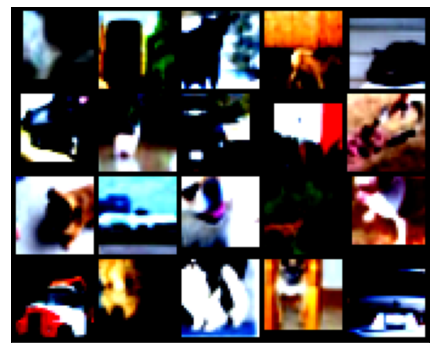

In [8]:
show_batch(train_loader)

### __The CIFAR-100 dataset__
This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
Here is the list of classes in the CIFAR-100:

https://www.cs.toronto.edu/~kriz/cifar.html

In [9]:
# The 100 classes in the CIFAR-100 are grouped into 20 superclasses.
# 20 superclasses
Superclases = ('aquatic mammals', 'fish', 'flowers', 'food containers',
               'fruit and vegetables', 'household electrical devices',
               'household furniture', 'insects', 'large carnivores',
               'large man-made outdoor things', 'large natural outdoor scenes', 
               'large omnivores and herbivores', 'medium-sized mammals',
               'non-insect invertebrates', 'people', 'reptiles',
               'small mammals', 'trees', 'vehicles 1', 'vehicles 2')

# 100 classes
classes = ('beaver', 'dolphin', 'otter', 'seal', 'whale',
           'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
           'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
           'bottles', 'bowls', 'cans', 'cups', 'plates',
           'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
           'clock', 'computer keyboard', 'lamp', 'telephone', 'television',
           'bed', 'chair', 'couch', 'table', 'wardrobe',
           'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
           'bear', 'leopard', 'lion', 'tiger', 'wolf',
           'bridge', 'castle', 'house', 'road', 'skyscraper',
           'cloud', 'forest', 'mountain', 'plain', 'sea',
           'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
           'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
           'crab', 'lobster', 'snail', 'spider', 'worm',
           'baby', 'boy', 'girl', 'man', 'woman',
           'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
           'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
           'maple', 'oak', 'palm', 'pine', 'willow',
           'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
           'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor')

# <font color='darkblue'>3. Обучение классификатора картинок, на примере CIFAR-100, сверточной сетью (самописной)</font> 

# 3.1 Пишем архитектуру сети

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        ## Для CIFAR100
        self.fc2 = torch.nn.Linear(200, 150)
        self.out = torch.nn.Linear(150, 100)
        ## Для CIFAR10
        # self.fc2 = torch.nn.Linear(200, 60)
        # self.out = torch.nn.Linear(60, 10)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        
        return self.out(x)

# Создаём экземпляр класса Net()       
model = Net()
# print(model)

In [11]:
# import torch.nn.functional as F
# from tqdm import tqdm

In [12]:
# Функция потерь
criterion = nn.CrossEntropyLoss()
# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 3.2 Обучаем и тестируем

In [13]:
for epoch in tqdm(range(10)):  
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()

        outputs = model(inputs)
        # if i==0:
        #   print('\n'+'*'*100)
        #   print(f'\n\nlabels={labels},\noutputs={outputs[1]}')
        #   print('\n'+'*'*100)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    model.eval()
    loss_accumed = 0
    for X, y in test_loader:
        output = model(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 10%|█         | 1/10 [01:38<14:50, 98.90s/it]

Epoch 0 valid_loss 123.77166748046875


 20%|██        | 2/10 [03:11<12:43, 95.39s/it]

Epoch 1 valid_loss 116.73970031738281


 30%|███       | 3/10 [04:43<10:55, 93.60s/it]

Epoch 2 valid_loss 106.4568099975586


 40%|████      | 4/10 [06:17<09:22, 93.77s/it]

Epoch 3 valid_loss 114.77180480957031


 50%|█████     | 5/10 [07:49<07:46, 93.37s/it]

Epoch 4 valid_loss 99.08961486816406


 60%|██████    | 6/10 [09:32<06:26, 96.63s/it]

Epoch 5 valid_loss 93.23388671875


 70%|███████   | 7/10 [11:06<04:46, 95.64s/it]

Epoch 6 valid_loss 106.19073486328125


 80%|████████  | 8/10 [12:44<03:12, 96.45s/it]

Epoch 7 valid_loss 97.37362670898438


 90%|█████████ | 9/10 [14:20<01:36, 96.31s/it]

Epoch 8 valid_loss 102.12936401367188


100%|██████████| 10/10 [15:57<00:00, 95.79s/it]

Epoch 9 valid_loss 100.9736557006836
Training is finished!


# <font color='darkblue'>4. Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50</font> 

In [38]:
from torchvision import models

# resnet_50 = models.resnet50()
resnet_50 = models.resnet50(pretrained=True)  # Предобучаем сеть

In [39]:
print(resnet_50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [40]:
# Необходимые трансформации
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), normalize, transforms.ToTensor()])

In [41]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

# trans_actions = transforms.Compose([transforms.Scale(256),
#                                     transforms.RandomCrop(224, padding=4),
#                                     transforms.ToTensor(),
#                                     normalize])

In [42]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [43]:
set_parameter_requires_grad(resnet_50, True)
# resnet_18.fc = nn.Linear(512, 10)
resnet_50.fc = nn.Linear(2048, 100)

In [44]:
params_to_update = []
for name,param in resnet_50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

print(params_to_update)

[Parameter containing:
tensor([[ 0.0034, -0.0115, -0.0017,  ...,  0.0128, -0.0126, -0.0127],
        [ 0.0195,  0.0091, -0.0095,  ..., -0.0178, -0.0136,  0.0062],
        [-0.0038,  0.0063,  0.0158,  ..., -0.0172, -0.0054,  0.0091],
        ...,
        [ 0.0078,  0.0198,  0.0059,  ..., -0.0214, -0.0085,  0.0149],
        [-0.0145, -0.0072, -0.0107,  ..., -0.0150,  0.0086, -0.0154],
        [-0.0056,  0.0146,  0.0162,  ..., -0.0126,  0.0006,  0.0154]],
       requires_grad=True), Parameter containing:
tensor([-0.0085, -0.0221,  0.0159, -0.0178,  0.0084, -0.0080,  0.0091,  0.0203,
         0.0077, -0.0046,  0.0115, -0.0021,  0.0063,  0.0096, -0.0113,  0.0175,
        -0.0025,  0.0060,  0.0112, -0.0131,  0.0006, -0.0019,  0.0162,  0.0037,
         0.0219, -0.0218,  0.0015, -0.0139, -0.0159,  0.0042, -0.0199,  0.0065,
         0.0062,  0.0040, -0.0140, -0.0163, -0.0156, -0.0192,  0.0187, -0.0115,
        -0.0004,  0.0005,  0.0219, -0.0196, -0.0130, -0.0033, -0.0127, -0.0185,
         0.01

In [45]:
# resnet_50.layer3 = Net()
# resnet_50.layer4 = Net()
# resnet_50.fc = Net()
# print(resnet_50.fc)

In [46]:
optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

Fine-tuning - заморозка сети

In [47]:
for epoch in tqdm(range(10)):  
    resnet_50.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()

        outputs = resnet_50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    resnet_50.eval()
    loss_accumed = 0
    for X, y in test_loader:
        output = resnet_50(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 10%|█         | 1/10 [07:32<1:07:53, 452.57s/it]

Epoch 0 valid_loss 137.86070251464844


 20%|██        | 2/10 [15:19<1:01:28, 461.01s/it]

Epoch 1 valid_loss 130.12818908691406


 30%|███       | 3/10 [23:24<55:02, 471.76s/it]  

Epoch 2 valid_loss 129.61399841308594


 40%|████      | 4/10 [31:05<46:45, 467.51s/it]

Epoch 3 valid_loss 128.58567810058594


 50%|█████     | 5/10 [38:58<39:08, 469.66s/it]

Epoch 4 valid_loss 125.10343170166016


 60%|██████    | 6/10 [46:38<31:05, 466.44s/it]

Epoch 5 valid_loss 132.31607055664062


 70%|███████   | 7/10 [54:18<23:13, 464.42s/it]

Epoch 6 valid_loss 132.4649200439453


 80%|████████  | 8/10 [1:01:55<15:23, 461.77s/it]

Epoch 7 valid_loss 130.40292358398438


 90%|█████████ | 9/10 [1:09:30<07:39, 459.69s/it]

Epoch 8 valid_loss 133.65895080566406


100%|██████████| 10/10 [1:17:12<00:00, 463.26s/it]

Epoch 9 valid_loss 130.14093017578125
Training is finished!


# <font color='darkblue'>5. Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50 с аугментацией (самописной, с использованием Pytorch встроенных методов)</font>

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
dataset = torchvision.datasets.CIFAR10(root='data/', train=True, download=True)

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]
    

Files already downloaded and verified


In [50]:
trans_actions = transforms.Compose([transforms.Scale(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=3)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [51]:
model = models.resnet50(pretrained=True)
set_parameter_requires_grad(model, True)

print(resnet_50.fc)

Linear(in_features=2048, out_features=100, bias=True)


In [54]:
# (fc): Linear(in_features=2048, out_features=1000, bias=True)

# model.fc = torch.nn.Linear(2048, 100)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(2048, 1024),
    torch.nn.Linear(1024, 512),
    torch.nn.Linear(512, 256),
    torch.nn.Linear(256, 128),
    torch.nn.Linear(128, 100)  # len(train_dataset.classes)
)

In [55]:
params_to_update = []
for name,param in resnet_50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# optimizer = torch.optim.Adam(params_to_update, lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # https://pytorch.org/docs/stable/optim.html
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in tqdm(range(10)):  
    resnet_50.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()

        outputs = resnet_50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    resnet_50.eval()
    loss_accumed = 0
    for X, y in test_loader:
        output = resnet_50(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


- Сверточная нейронная сеть на PyTorch: пошаговое руководство - https://neurohive.io/ru/tutorial/cnn-na-pytorch/

- How to use an optimizer -https://pytorch.org/docs/stable/optim.html

- Image Classification of CIFAR100 Dataset Using PyTorch - https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1